<a href="https://colab.research.google.com/github/shibinshibu01/stockPricePredict/blob/main/stockPricePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install pandas numpy matplotlib yfinance scikit-learn

In [10]:
from sklearn.impute import SimpleImputer

[*********************100%***********************]  1 of 1 completed
Mean Squared Error: 2.6259466698729317
Mean Absolute Error: 1.2416062520977744
R-squared: 0.9972348054136717
[*********************100%***********************]  1 of 1 completed


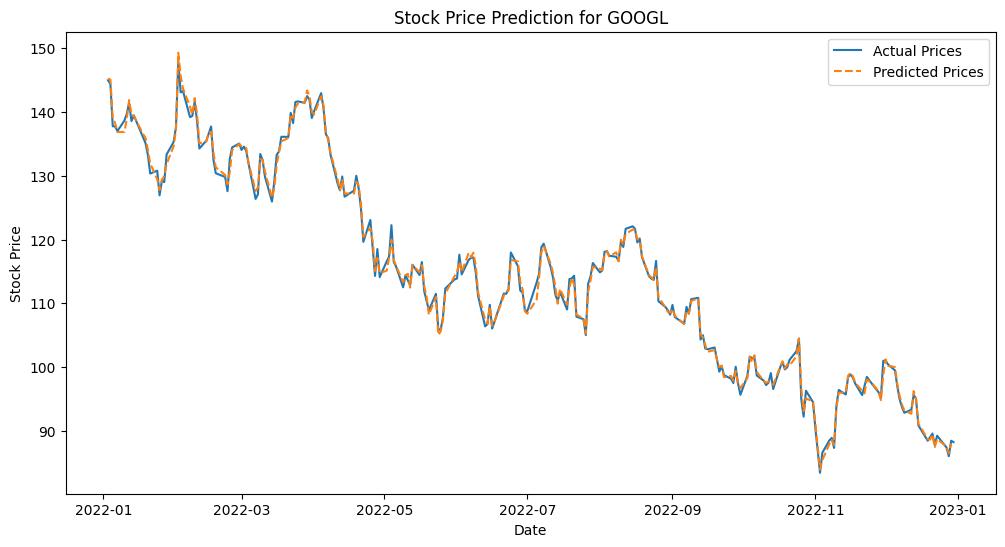

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer  # Added for handling missing values
import matplotlib.pyplot as plt

# Data Collection
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Data Preprocessing and Feature Engineering
def preprocess_data(data):
    # Drop missing values in the target variable (y)
    data.dropna(subset=['Close'], inplace=True)

    # Calculate additional technical indicators
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data['Close'])
    data['MACD'] = calculate_macd(data['Close'])

    # Feature Selection
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD']
    X = data[features]
    y = data['Close'].shift(-1)  # Next day's closing price as the target variable

    # Handle missing values in features (X) using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    return X[:-1], y[:-1]

# Calculate Relative Strength Index (RSI)
def calculate_rsi(close_prices, period=14):
    # Calculate price changes and gains/losses
    delta = close_prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gains and losses
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    # Calculate RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(close_prices, short_window=12, long_window=26, signal_window=9):
    short_ema = close_prices.ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = close_prices.ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    macd_signal = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line - macd_signal

# Model Training and Evaluation
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

if __name__ == '__main__':
    # Replace the ticker, start_date, and end_date for GOOGL
    ticker = 'GOOGL'
    start_date = '2020-01-01'
    end_date = '2021-12-31'

    # Data Collection
    data = get_stock_data(ticker, start_date, end_date)

    # Data Preprocessing and Feature Engineering
    X, y = preprocess_data(data)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model Training
    model = train_linear_regression(X_train, y_train)

    # Model Evaluation
    mse, mae, r2 = evaluate_model(model, X_test, y_test)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Make predictions on future stock prices
    future_data = get_stock_data(ticker, '2022-01-01', '2022-12-31')
    X_future, _ = preprocess_data(future_data)
    future_predictions = model.predict(X_future)

    # Create a new index with the appended date
    future_dates = future_data.index.append(pd.to_datetime(['2023-01-01']))

    # Create a new index without the last date to match the length of future_predictions
    future_dates = future_data.index[:-1]

    # Visualize predicted prices alongside actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(future_data.index, future_data['Close'], label='Actual Prices')
    plt.plot(future_dates, future_predictions, label='Predicted Prices', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction for GOOGL')
    plt.legend()
    plt.show()
